# 백테스팅 시뮬레이션

## bt 패키지

### 데이터의 수집

In [1]:
# bt 패키지의 get() 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해준다.
import bt

data = bt.get('SPY, TLT', start='2003-01-01', end='2021-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,spy,tlt
Date,,
2003-01-02,61.366570,43.399567
2003-01-03,61.555233,43.500141
2003-01-06,62.640133,43.384457
2003-01-07,62.485130,43.540421
2003-01-08,61.582191,43.756664


In [3]:
from sqlalchemy import create_engine
import pandas as pd
import keyring

user = 'root'
pw = keyring.get_password('macmini_db', user)
host = '192.168.219.106'
engine = create_engine(f'mysql+pymysql://{user}:{pw}@{host}:3306/stock')
price = pd.read_sql('SELECT * FROM sample_etf;', con=engine)
engine.dispose()

price.tail()

,Date,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
7760,2023-11-22,455.019989,50.160000,62.490002,39.520000,90.870003,92.750000,82.250000,24.920000,184.559998,24.180000
7761,2023-11-24,455.299988,50.669998,62.610001,39.540001,89.800003,92.269997,82.550003,25.049999,185.520004,24.020000
7762,2023-11-27,454.480011,50.500000,62.560001,39.380001,91.300003,92.970001,82.849998,25.049999,186.770004,23.860001
7763,2023-11-28,454.929993,50.490002,62.549999,39.709999,91.480003,93.379997,83.339996,25.120001,189.259995,24.150000
7764,2023-11-29,454.609985,50.689999,62.490002,39.480000,92.629997,93.870003,83.949997,25.170000,189.539993,24.320000


### 전략의 정의

In [4]:
import bt

# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW", [        # 전략의 이름
    bt.algos.SelectAll(),                   # 모든 데이터를 사용함을 정의
    bt.algos.WeighEqually(),                # 동일 비중으로 투자할 것을 정의
    bt.algos.RunMonthly(),                  # 매 월말 리밸런싱
    bt.algos.Rebalance()                    # 계산된 비중에 따라 리밸런싱
])

### 전략의 백테스트

In [7]:
data = price.dropna()       # 시작점이 모두 다르므로, dropna() 함수를 통해 NA를 모두 제거
data.set_index('Date', inplace=True)

# 백테스트 생성
backtest = bt.Backtest(strategy, data)

# 백테스트 실행
result = bt.run(backtest)

### 결과에 대한 평가

In [9]:
# prices : 누적 수익률, 시작 시점을 100으로 환산하여 계산
result.prices

,Asset_EW
2006-12-18,100.000000
2006-12-19,100.000000
2006-12-20,100.208601
2006-12-21,100.077613
2006-12-22,100.038759
...,...
2023-11-22,205.809861
2023-11-24,205.898856
2023-11-27,206.268547
2023-11-28,207.269442


In [11]:
# prices에 to_returns()를 입력하면 수익률이 계산된다.
result.prices.to_returns()

,Asset_EW
2006-12-18,NaN
2006-12-19,0.000000
2006-12-20,0.002086
2006-12-21,-0.001307
2006-12-22,-0.000388
...,...
2023-11-22,0.000360
2023-11-24,0.000432
2023-11-27,0.001795
2023-11-28,0.004852


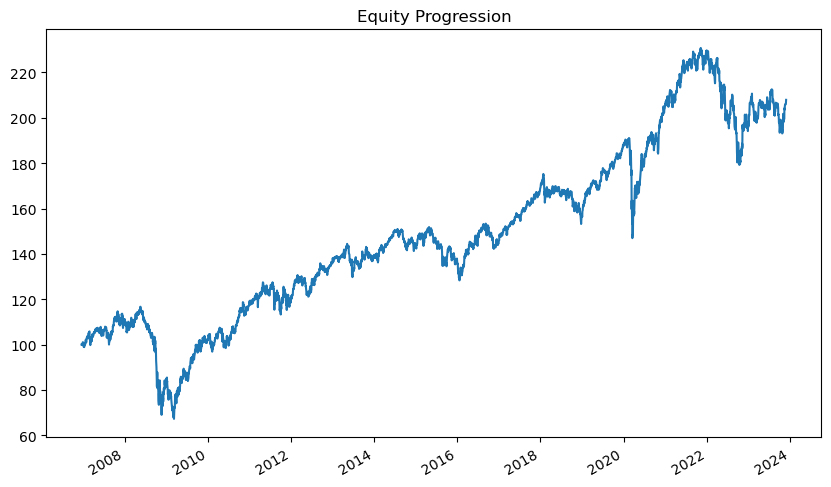

In [13]:
import matplotlib.pyplot as plt

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [14]:
# get_security_weights() 메서드를 통해 각 종목별 추자 비중 확인 가능
result.get_security_weights().head()

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
2006-12-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-19,0.099999,0.099998,0.099996,0.099994,0.099981,0.100000,0.099994,0.099978,0.099992,0.099998
2006-12-20,0.099735,0.099210,0.100498,0.100890,0.099762,0.099768,0.100615,0.099967,0.099494,0.099992
2006-12-21,0.099500,0.099391,0.101205,0.100841,0.100394,0.100259,0.099778,0.100213,0.099236,0.099114
2006-12-22,0.098927,0.098789,0.101604,0.101242,0.099664,0.099841,0.099042,0.101191,0.099711,0.099919


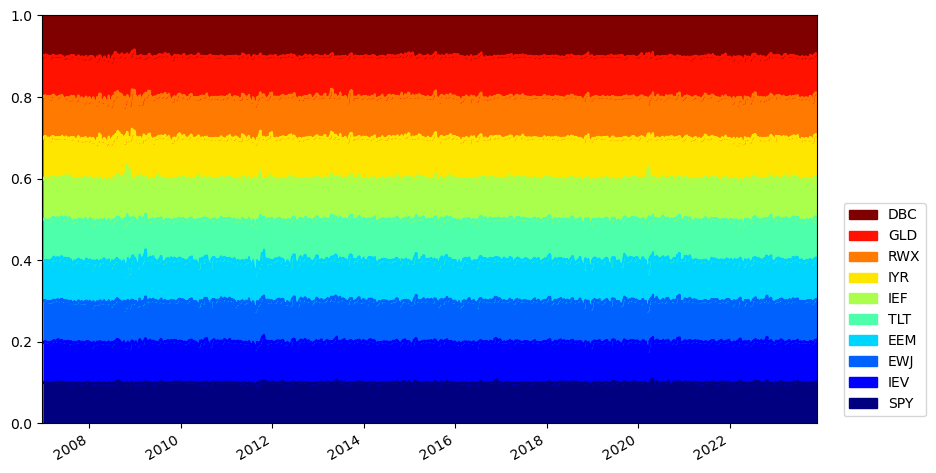

In [15]:
# plot weights
from matplotlib import cm

# area()를 통해 면적 그래프를 나타내며, y축의 범위는 0에서 1, 범례(legend) 제외, 색 구분은 cm.jet 활용
ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                        ylim=[0, 1],
                                        legend=False,
                                        colormap=cm.jet)
# get_legend_handles_labels() 함수를 통해 범례를 받아온다.
handles, labels = ax.get_legend_handles_labels()
# 좌우 마진 0
plt.margins(0, 0)
# legend() 함수를 통해 범례를 나타내며, 그래프와 색 순서를 맞추기 위해 reversed()를 통해 순서를 바꾼다. 
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()


In [16]:
# 성과지표 확인
result.display()

Stat                 Asset_EW
-------------------  ----------
Start                2006-12-18
End                  2023-11-29
Risk-free rate       0.00%

Total Return         107.93%
Daily Sharpe         0.39
Daily Sortino        0.60
CAGR                 4.41%
Max Drawdown         -42.35%
Calmar Ratio         0.10

MTD                  7.12%
3m                   0.67%
6m                   2.83%
YTD                  6.19%
1Y                   5.78%
3Y (ann.)            1.63%
5Y (ann.)            5.27%
10Y (ann.)           4.06%
Since Incep. (ann.)  4.41%

Daily Sharpe         0.39
Daily Sortino        0.60
Daily Mean (ann.)    5.25%
Daily Vol (ann.)     13.61%
Daily Skew           -0.21
Daily Kurt           10.24
Best Day             7.81%
Worst Day            -6.77%

Monthly Sharpe       0.41
Monthly Sortino      0.66
Monthly Mean (ann.)  5.02%
Monthly Vol (ann.)   12.16%
Monthly Skew         -0.82
Monthly Kurt         3.62
Best Month           8.67%
Worst Month          -17.98%

Year

## 정적 자산배분 : 올웨더 포트폴리오